In [8]:
project_id = 'possible-helix-330610'

In [9]:
import pandas as pd
import numpy as np

query = """
SELECT 
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    count(*) as cnt
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY pickup_hour
ORDER BY pickup_hour
"""

df = pd.read_gbq(query=query, dialect='standard', 
                 project_id=project_id,
                 reauth=True,
                 auth_local_webserver=True)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=BgOHrZlvb55896mxpBhFOt0zqDxwml&access_type=offline


In [10]:
df.tail(10)

,pickup_hour,cnt
734,2015-01-31 14:00:00,25059
735,2015-01-31 15:00:00,25886
736,2015-01-31 16:00:00,23822
737,2015-01-31 17:00:00,25794
738,2015-01-31 18:00:00,30804
739,2015-01-31 19:00:00,32436
740,2015-01-31 20:00:00,27555
741,2015-01-31 21:00:00,27477
742,2015-01-31 22:00:00,29862
743,2015-01-31 23:00:00,29856


In [17]:
df.info # prints the type of columns and memory usage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   pickup_hour  744 non-null    datetime64[ns]
 1   cnt          744 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.8 KB


### Optimizing the Pandas:
- Memory optimization
- Enhancing performance
- Adopting convention

int 32 is better than int 64 in terms of memory usage.

https://drive.google.com/file/d/12faqaslFIF-Sg_sU3jeGyauW5ClRqS8D/view

https://rfriend.tistory.com/285

category > object in terms of speed

In [11]:
def reduce_mem_usage(df):
    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f}MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
            else:
                pass
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f}MB')
    print(f'Decreased by {100*((start_mem - end_mem)/start_mem):.1f}%')
    
    return df

In [12]:
new_df = reduce_mem_usage(df)

Memory usage of dataframe is 0.01MB
Memory usage after optimization is: 0.01MB
Decreased by 24.7%


In [13]:
new_df.info()
# 11.7KB -> 8.8KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   pickup_hour  744 non-null    datetime64[ns]
 1   cnt          744 non-null    int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 8.8 KB


In [14]:
# count instances of each column
new_df['pickup_hour'].value_counts()

2015-01-01 00:00:00    1
2015-01-21 19:00:00    1
2015-01-21 10:00:00    1
2015-01-21 11:00:00    1
2015-01-21 12:00:00    1
                      ..
2015-01-11 10:00:00    1
2015-01-11 11:00:00    1
2015-01-11 12:00:00    1
2015-01-11 13:00:00    1
2015-01-31 23:00:00    1
Name: pickup_hour, Length: 744, dtype: int64

In [ ]:
# DATETIME EXTRACT
new_df['pickup_hour'].dt

In [ ]:
new_df['year'] = new_df['pickup_hour'].dt.year
new_df['month'] = new_df['pickup_hour'].dt.month
new_df['day'] = new_df['pickup_hour'].dt.day
new_df['hour'] = new_df['pickup_hour'].dt.hour
new_df['weekday'] = new_df['pickup_hour'].dt.weekday

In [ ]:
new_df.head()

,pickup_hour,cnt,year,month,day,hour,weekday
0,2015-01-01 00:00:00,28312,2015,1,1,0,3
1,2015-01-01 01:00:00,31707,2015,1,1,1,3
2,2015-01-01 02:00:00,28068,2015,1,1,2,3
3,2015-01-01 03:00:00,24288,2015,1,1,3,3
4,2015-01-01 04:00:00,17081,2015,1,1,4,3


#### Comparing different extraction methods

https://www.listendata.com/2019/07/how-to-filter-pandas-dataframe.html

In [60]:
%%timeit 100
new_df[new_df['month'] == 1][new_df['day'] == 10][new_df['hour']==10]

4.65 ms ± 76.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [65]:
%%timeit 100
new_df[(new_df['month'] == 1) & (new_df['day']==10) & (new_df['hour']==10)]

2.53 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [62]:
%%timeit 100
new_df.loc[(new_df['month'] == 1) & (new_df['day'] == 10) & (new_df['hour'] == 10)]

2.8 ms ± 260 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [66]:
%%timeit 100
new_df.query('month == 1 & day == 10 & hour == 10')

6.88 ms ± 273 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Pivot Table

#### Reshaping and pivot tables

##### Reshaping by pivoting DataFrame objects

https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html

pivot이 있고 pivot_table이 있음.
pivot_table이 더 high level.
groupby와 unstack을 사용해도 동일한 결과를 얻을 수 있음.

pivot_table은 위 결과에서 aggfunc(집계)를 진행

generate an identical pivot table using different methods

In [78]:
%%timeit
df.pivot_table('cnt', index='hour', columns='weekday', aggfunc='mean').head()

18.1 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [84]:
%%timeit
df.groupby(['hour', 'weekday'])['cnt'].mean().unstack().head()

3.62 ms ± 231 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


##### groupby is much faster!

### 날짜 더미 데이터 생성하기
pd.date_range() 사용

In [ ]:
pd.date_range(start='2021-01-01', end='2022-01-01', freq='1H')

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 01:00:00',
               '2021-01-01 02:00:00', '2021-01-01 03:00:00',
               '2021-01-01 04:00:00', '2021-01-01 05:00:00',
               '2021-01-01 06:00:00', '2021-01-01 07:00:00',
               '2021-01-01 08:00:00', '2021-01-01 09:00:00',
               ...
               '2021-12-31 15:00:00', '2021-12-31 16:00:00',
               '2021-12-31 17:00:00', '2021-12-31 18:00:00',
               '2021-12-31 19:00:00', '2021-12-31 20:00:00',
               '2021-12-31 21:00:00', '2021-12-31 22:00:00',
               '2021-12-31 23:00:00', '2022-01-01 00:00:00'],
              dtype='datetime64[ns]', length=8761, freq='H')

In [89]:
pd.date_range(start='2021-01-01', end='2022-01-01', freq='1D')

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2021-12-23', '2021-12-24', '2021-12-25', '2021-12-26',
               '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30',
               '2021-12-31', '2022-01-01'],
              dtype='datetime64[ns]', length=366, freq='D')

### String Value에 특정 단어가 포함되는지
df['col_name'].str.contains 사용

In [18]:
# 이번 데이터셋엔 str 값이 없으므로 hour를 임시로 str로 바꾸고
new_df['string_hour'] = new_df['hour'].astype(str)

# 여러 조건일 경우 | 사용
new_df.loc[new_df['string_hour'].str.contains("10|11")==True].head()

,pickup_hour,cnt,year,month,day,hour,weekday,string_hour
10,2015-01-01 10:00:00,9949,2015,1,1,10,3,10
11,2015-01-01 11:00:00,13870,2015,1,1,11,3,11
34,2015-01-02 10:00:00,15243,2015,1,2,10,4,10
35,2015-01-02 11:00:00,16999,2015,1,2,11,4,11
58,2015-01-03 10:00:00,14975,2015,1,3,10,5,10


### 이동 평균 및 Lag
- 이동 평균
    - Series.rolling() 사용
    - datetime64 타입을 지정해서 사용하면 NotImplementedError 발생

            - 이럴 경우 set_index()로 인덱스 지정하고 사용

- Lag 함수
    - Series.shift() 사용

In [19]:
new_df = new_df.set_index('pickup_hour')
new_df['moving_average'] = new_df['cnt'].rolling(window=3, center=False).mean()
new_df['lag_cnt'] = new_df['cnt'].shift(1)
new_df.head()

,cnt,year,month,day,hour,weekday,string_hour,moving_average,lag_cnt
pickup_hour,,,,,,,,,
2015-01-01 00:00:00,28312,2015,1,1,0,3,0,NaN,NaN
2015-01-01 01:00:00,31707,2015,1,1,1,3,1,NaN,28312.0
2015-01-01 02:00:00,28068,2015,1,1,2,3,2,29362.333333,31707.0
2015-01-01 03:00:00,24288,2015,1,1,3,3,3,28021.000000,28068.0
2015-01-01 04:00:00,17081,2015,1,1,4,3,4,23145.666667,24288.0


### fillna, merge, concat 등
- fillna : na값 채우기
- merge : SQL의 join과 비슷
- concat : axis=1, axis=0으로 붙이기



In [20]:
# display max row 설정
pd.set_option('display.max_rows', 1000)

# Plot 그릴시 레티나로 그리기(Mac에서 더 또렷하게)
# %config InlineBackend.figure_format = 'retina'

# 이걸 설정하면 한 셀에서 Multiple Output Print 가능
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

1) Pandas + BigQuery => pd.read_gbq()
2) 컬럼 타입 변경 => Memory 사용량 감소
3) 컬럼별 값이 얼마나 있는지 => value_counts()
4) Datetime 추출하고 싶은 경우 => df['datetime_column'].dt.~~~
5) Filtering
df[특정 조건][특정 조건]
df[ (T or F가 나오는 연산) & (T or F가 나오는 연산) ]
loc 사용
query 사용
6) Pivot Table
7) 재구조화 : stack(), unstack(), melt(), .reset_index()
8) 날짜 더미 데이터 생성 : pd.data_range()
9) String value 확인 : df['col_name'].str.contains()
10) 이동 평균 : Series.rolling, 이전 값(Lag) : Series.shift()
11) 기타 : fillna, merge, concat
12) notebook setting
13) Pandas Anti Pattern을 피합시다! : pd.apply(), pd.iterrows() 사용은 고민해보고 결정하기

In [105]:
# !pip3 install cufflinks
# !pip3 install seaborn
# !pip3 install chart-studio

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11448 sha256=3ab79847adc014756d9da9baaf38df2eab704714442388afb7faa96369c210dc
  Stored in directory: c:\users\aurskog\appdata\local\pip\cache\wheels\c4\a7\48\0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x259a0bffee0>
C:\JupyterLab\resources\jlab_server\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
  return process_handler(cmd, _system_body)
C:\JupyterLab\resources\jlab_server\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  return process_handler(cmd, _system_body)
C:\JupyterLab\resources\jlab_server\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)


In [21]:
import chart_studio.plotly as py
import cufflinks as cf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
print(cf.__version__)

%config InlineBackend.figure_format = 'retina'
cf.go_offline()

0.17.3


In [22]:
%%time 
# CPU time not measured on Windows?
query = """
SELECT 
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    count(*) as cnt
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY pickup_hour
ORDER BY pickup_hour
"""

df = pd.read_gbq(query=query, dialect='standard', project_id=project_id)

Wall time: 1.55 s


In [23]:
# pickup_hour가 이미 datetime이라 아래 to_datetime은 안해도 되지만, 
# 혹시 필요하신 분을 위해 남겨둠
# df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])
df = df.set_index('pickup_hour')

In [24]:
df.head()

,cnt
pickup_hour,
2015-01-01 00:00:00,28312
2015-01-01 01:00:00,31707
2015-01-01 02:00:00,28068
2015-01-01 03:00:00,24288
2015-01-01 04:00:00,17081


In [1]:
# Check that jupyterlab-plotly is installed
!jupyter labextension list

JupyterLab v3.2.1
C:\JupyterLab\resources\jlab_server\share\jupyter\labextensions
        jupyterlab-plotly v5.3.1 enabled ok
        @jupyter-widgets/jupyterlab-manager v3.0.1 enabled ok (python, jupyterlab_widgets)

Other labextensions (built into JupyterLab)
   app dir: C:\JupyterLab\resources\jlab_server\share\jupyter\lab
        jupyterlab-dash v0.4.0 enabled ok


Build recommended, please run `jupyter lab build`:
    jupyterlab-dash needs to be included in build


In [51]:
#https://plotly.com/python/renderers/

import pandas as pd
import plotly.express as px
import plotly.io as pio

for text in pio.renderers:
   print(text)
pio.renderers.default = text

plotly_mimetype
jupyterlab
nteract
vscode
notebook
notebook_connected
kaggle
azure
colab
cocalc
databricks
json
png
jpeg
jpg
svg
pdf
browser
firefox
chrome
chromium
iframe
iframe_connected
sphinx_gallery
sphinx_gallery_png


In [48]:
pio.renderers.default = 'colab'

In [50]:
# Set jupyterlab mode to work in offline
layout1 = cf.Layout(
    height=500,
    width=800
)

df.iplot(kind='scatter',xTitle='Datetimes',yTitle='Demand',title='NYC Taxi Demand(2015-01)', layout=layout1)

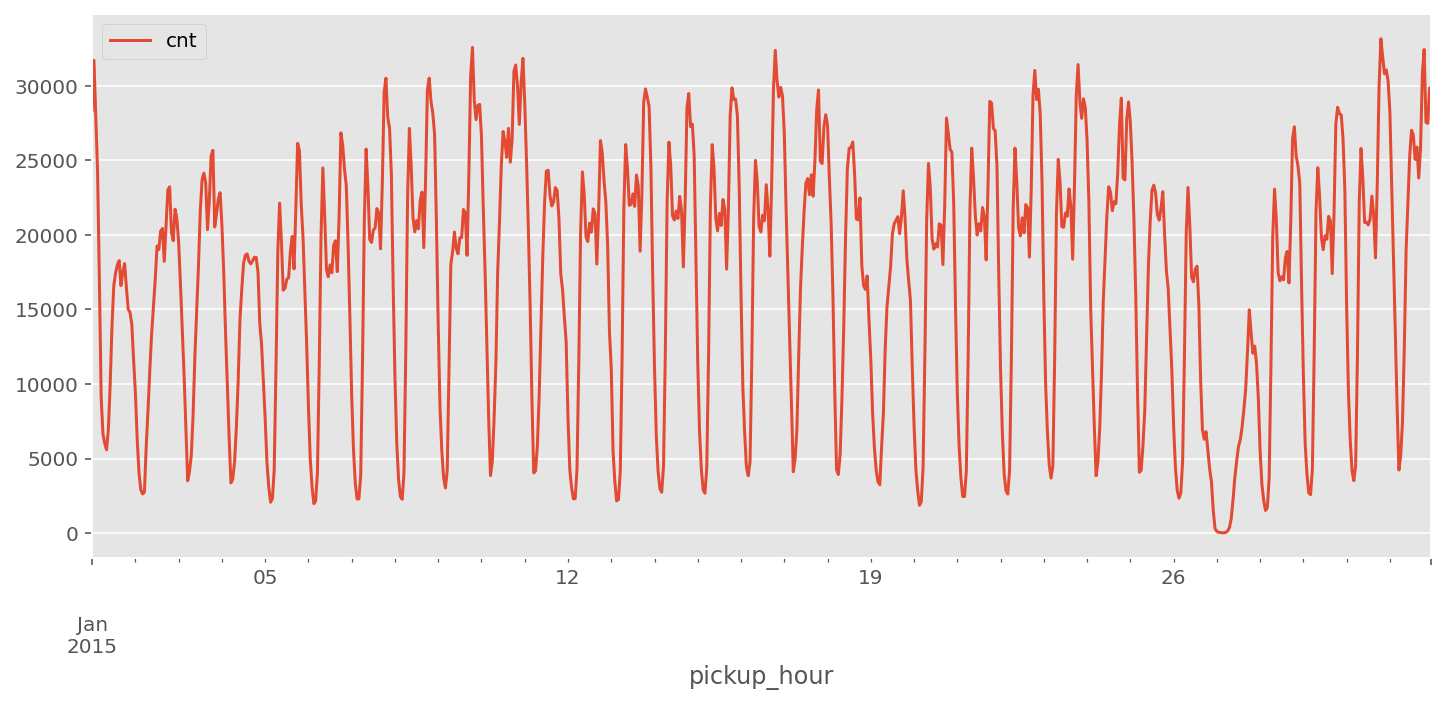

In [117]:
df.plot(kind='line', figsize=(12, 5));

In [5]:
!jupyter labextension list

JupyterLab v3.2.1
C:\JupyterLab\resources\jlab_server\share\jupyter\labextensions
        jupyterlab-plotly v5.3.1 enabled ok
        @jupyter-widgets/jupyterlab-manager v3.0.1 enabled ok (python, jupyterlab_widgets)

Other labextensions (built into JupyterLab)
   app dir: C:\JupyterLab\resources\jlab_server\share\jupyter\lab
        jupyterlab-dash v0.4.0 enabled ok
        plotlywidget v4.14.3 enabled ok



In [2]:
!jupyter lab build

[LabBuildApp] JupyterLab 3.2.1
[LabBuildApp] Building in C:\JupyterLab\resources\jlab_server\share\jupyter\lab
[LabBuildApp] Building jupyterlab assets (production, minimized)


In [4]:
!jupyter labextension install plotlywidget

Building jupyterlab assets (production, minimized)


In [7]:
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import iplot
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/gapminder2007.csv')

fig = go.Figure(go.Scatter(x=df.gdpPercap, y=df.lifeExp, text=df.country, mode='markers', name='2007'))
fig.update_xaxes(title_text='GDP per Capita', type='log')
fig.update_yaxes(title_text='Life Expectancy')
py.iplot(fig, filename='pandas-multiple-scatter')

PlotlyRequestError: Authentication credentials were not provided.